Από την Ομάδα 70, που αποτελείται από τους:
* Ιωάννης Μιχαήλ Καζελίδης 03117885
* Μάριος Κερασιώτης 03117890
* Ιωάννης Γκιορτζής 03117152

Στην ομάδα μας αντιστοιχούν τα εξής datasets:
* U09: Connectionist Bench (Sonar, Mines vs. Rocks)
* K02: Company Bankruptcy Prediction

# UCI: Connectionist Bench (Sonar, Mines vs. Rocks)

In [1]:
# !pip3 install -q -U pip matplotlib numpy pandas seaborn scikit-learn

In [2]:
DATASET_URI = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
PICKLE_FILE = 'sonar.all-data.df'

import os.path
import pickle
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tabulate
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from IPython.display import HTML, display
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import (
    SelectKBest,
    SelectPercentile,
    VarianceThreshold,
    chi2,
    f_classif,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, Normalizer, RobustScaler, StandardScaler

%matplotlib inline
sns.set(style='whitegrid', palette="cubehelix")
sns.set(rc={'figure.figsize': (20, 15)})
pd.options.display.max_columns = None

warnings.filterwarnings("ignore")

## Εισαγωγή και επισκόπηση

### Διερεύνηση του Dataset

In [3]:
if os.path.isfile(PICKLE_FILE):
    with open(PICKLE_FILE, 'rb') as f:
        data = pickle.load(f)
else:
    column_headers = ["T{}".format(str(i)) for i in range(60)]
    column_headers.append("Object")
    data = pd.read_csv(DATASET_URI, names=column_headers)

    with open(PICKLE_FILE, 'wb') as f:
        pickle.dump(data, f)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59,Object
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,0.3108,0.2933,0.2275,0.0994,0.1801,0.2200,0.2732,0.2862,0.2034,0.1740,0.4130,0.6879,0.8120,0.8453,0.8919,0.9300,0.9987,1.0000,0.8104,0.6199,0.6041,0.5547,0.4160,0.1472,0.0849,0.0608,0.0969,0.1411,0.1676,0.1200,0.1201,0.1036,0.1977,0.1339,0.0902,0.1085,0.1521,0.1363,0.0858,0.0290,0.0203,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,0.3085,0.3425,0.2990,0.1402,0.1235,0.1534,0.1901,0.2429,0.2120,0.2395,0.3272,0.5949,0.8302,0.9045,0.9888,0.9912,0.9448,1.0000,0.9092,0.7412,0.7691,0.7117,0.5304,0.2131,0.0928,0.1297,0.1159,0.1226,0.1768,0.0345,0.1562,0.0824,0.1149,0.1694,0.0954,0.0080,0.0790,0.1255,0.0647,0.0179,0.0051,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,0.2716,0.2374,0.1878,0.0983,0.0683,0.1503,0.1723,0.2339,0.1962,0.1395,0.3164,0.5888,0.7631,0.8473,0.9424,0.9986,0.9699,1.0000,0.8630,0.6979,0.7717,0.7305,0.5197,0.1786,0.1098,0.1446,0.1066,0.1440,0.1929,0.0325,0.1490,0.0328,0.0537,0.1309,0.0910,0.0757,0.1059,0.1005,0.0535,0.0235,0.0155,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,0.2898,0.2812,0.1578,0.0273,0.0673,0.1444,

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T0      208 non-null    float64
 1   T1      208 non-null    float64
 2   T2      208 non-null    float64
 3   T3      208 non-null    float64
 4   T4      208 non-null    float64
 5   T5      208 non-null    float64
 6   T6      208 non-null    float64
 7   T7      208 non-null    float64
 8   T8      208 non-null    float64
 9   T9      208 non-null    float64
 10  T10     208 non-null    float64
 11  T11     208 non-null    float64
 12  T12     208 non-null    float64
 13  T13     208 non-null    float64
 14  T14     208 non-null    float64
 15  T15     208 non-null    float64
 16  T16     208 non-null    float64
 17  T17     208 non-null    float64
 18  T18     208 non-null    float64
 19  T19     208 non-null    float64
 20  T20     208 non-null    float64
 21  T21     208 non-null    float64
 22  T2

In [5]:
features = data[data.columns.drop('Object')]
labels = data['Object'].astype('category')
del (data)

In [6]:
print("Dimensions of features:", features.shape)
print("Dimensions of labels:", labels.shape)

Dimensions of features: (208, 60)
Dimensions of labels: (208,)


In [7]:
print('Unique labels', np.unique(labels))
labels.value_counts() / len(labels)

Unique labels ['M' 'R']


M    0.533654
R    0.466346
Name: Object, dtype: float64

In [8]:
features.describe()

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,T41,T42,T43,T44,T45,T46,T47,T48,T49,T50,T51,T52,T53,T54,T55,T56,T57,T58,T59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,

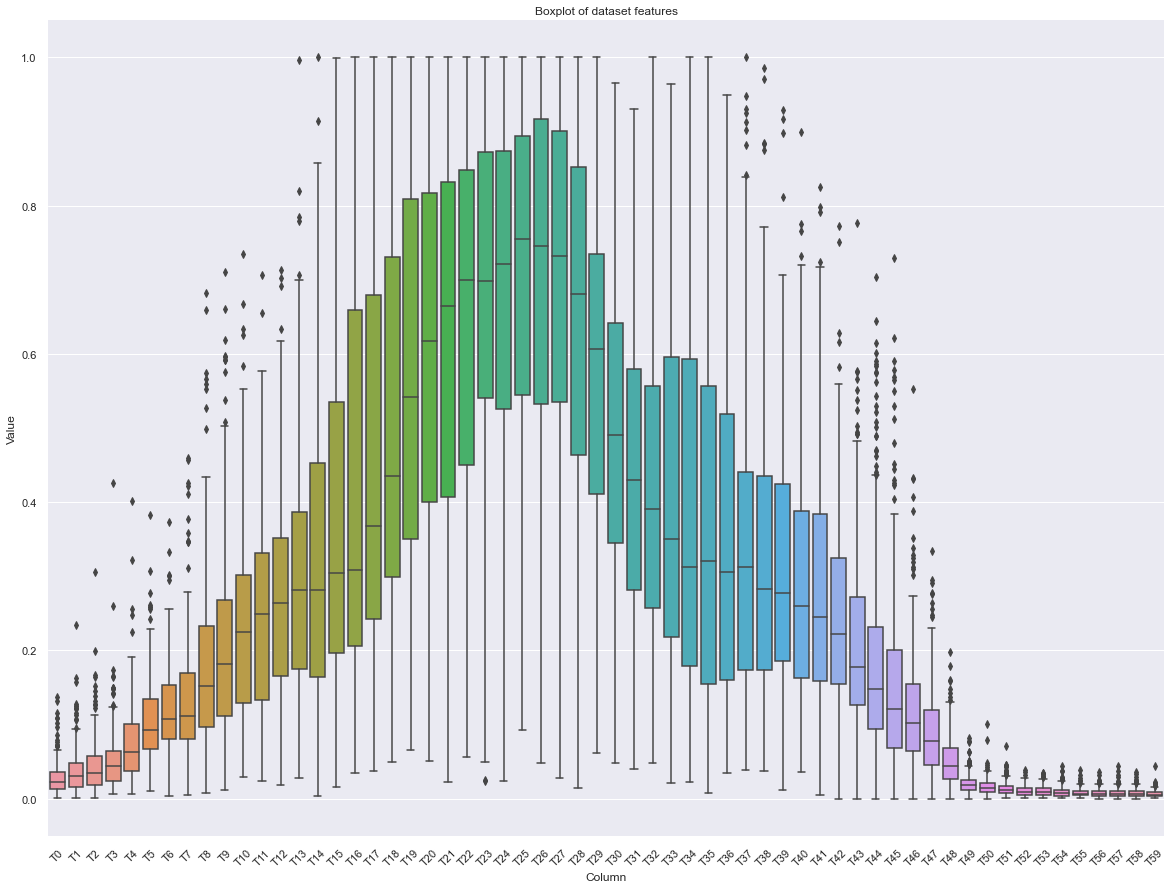

In [9]:
boxplot = sns.boxplot(data=features)
boxplot.set(title='Boxplot of dataset features',
            xlabel='Column',
            ylabel='Value')
sns.despine(offset=2)
plt.xticks(rotation=45)
plt.show()

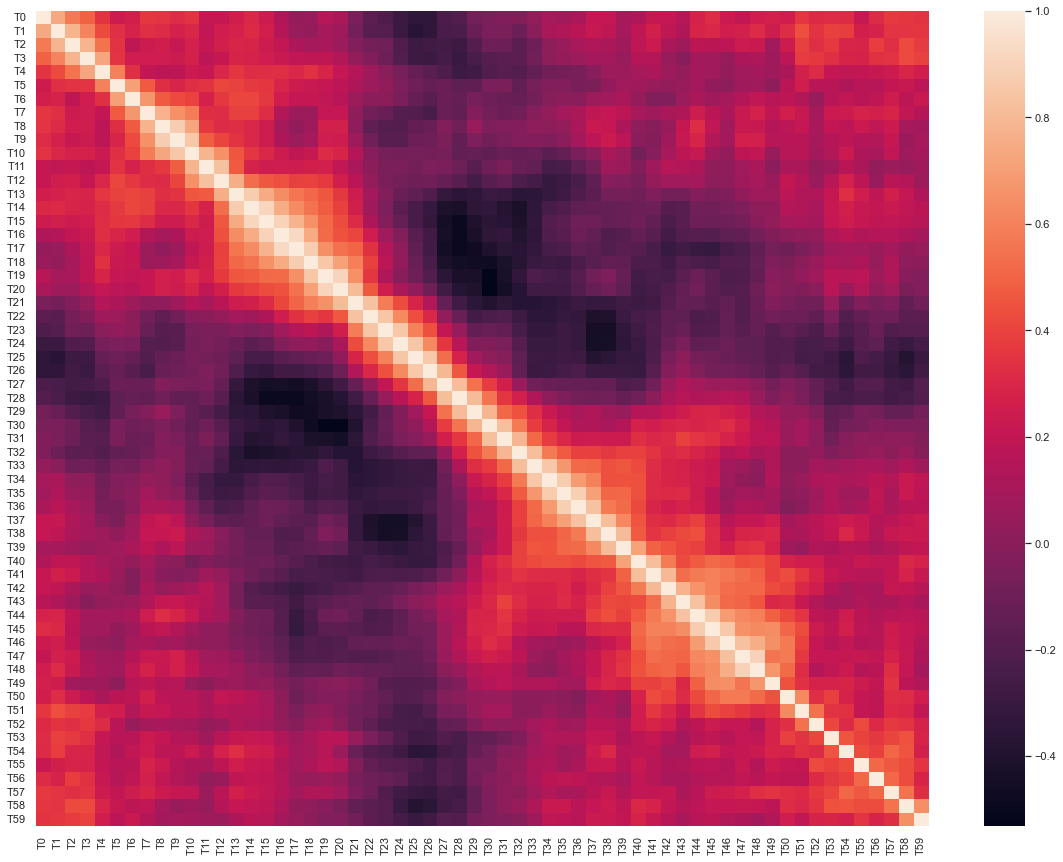

In [10]:
sns.heatmap(features.corr())
plt.show()

### Απάντηση στα ζητούμενα

1. Σύντομη Παρουσίαση Dataset και Περιγραφή Προβλήματος
     - Το γενικό πρόβλημα αποτελεί την κατηγοριοποίηση διαφόρων σημάτων με την βοήθεια ενός ταξινομητή. Ένα σύστημα SO.N.A.R. εκπέμπει σήματα, για τα οποία καλούμαστε να διακρίνουμε αν η επιφάνεια στην οποία ανακλώνται είναι μέταλλο ή πέτρα.

     - Το συγκεκριμένο dataset είναι ένα σύνολο μοτίβων από σήματα που λήφθηκαν από μεταλλικούς και πέτρινους κυλίνδρους. Κάθε γραμμή αποτελεί είτε έναν μεταλλικό είτε ένα πέτρινο κύλινδρο και οι μετρήσεις κατά μήκος της γραμμής είναι οι διάφορες ενέργειες των σημάτων σε διαφορετικές γωνίες και καταστάσεις του. Κάθε γραμμή περιέχει 60 μετρήσεις, καθώς και τον τύπο του κυλίνδρου στην 61η στήλη. Συνολικά υπάρχουν 208 τέτοιες γραμμές από τα διάφορα υλικά.  

2. Χρειάστηκε να κάνετε μετατροπές στα αρχεία plain text για την εισαγωγή του; αν ναι, ποιες είναι αυτές;
   - Δεν χρειάστηκε κάποια μετατροπή στα δεδομένα εκτός από το να διαβάζουμε το αρχείο σε μορφή csv (με την επιλογή να μην έχει το dataset κεφαλίδες).

3. Δώστε το πλήθος δειγμάτων και χαρακτηριστικών, και το είδος όλων των χαρακτηριστικών. Υπάρχουν μη διατεταγμένα χαρακτηριστικά και ποια είναι αυτά;
    - Συνολικά έχουμε 208 δείγματα. Από αυτά, τα 111 είναι μοτίβα τα οποία λαμβάνουμε από τους μεταλλικούς κυλίνδρους σε διαφορετικές γωνίες και καταστάσεις, ενώ τα 97 είναι μοτίβα τα οποία λαμβάνουμε από τις κυλινδρικές πέτρες κάτω από αντίστοιχες συνθήκες. Επίσης, για κάθε ένα από αυτά τα δείγματα, έχουμε 60 μετρήσεις, οι οποίες αναφέρονται σε ενέργεια, της οποίας η τιμή κυμαίνεται κάθε φορά από 0.0 έως 1.0 (στο dataset αυτές αναπαριστώνται ως float64), καθώς και ένα αναγνωριστικό που δείχνει την κλάση στην οποία ανήκει το δείγμα, με M για μέταλλο και R για πέτρα (στο dataset αυτό αναπαριστάται ως object). Αυτά τα "αναγνωριστικά" είναι και τα χαρακτηριστικά τα οποία είναι μη διατεταγμένα, εφόσον δεν είναι αριθμητικά, και έτσι δεν μπορούμε να τα διατάξουμε με κάποιο τρόπο.

4. Υπάρχουν επικεφαλίδες; Αρίθμηση γραμμών;
    - Το αρχείο αποτελείται μόνο από τα δεδομένα διαχωρισμένα με το σύμβολο `,` και δεν περιέχει ούτε κεφαλίδες ούτε αρίθμηση γραμμών. Κεφαλίδες προσθέσαμε εμείς ύστερα στο dataframe.

5. Ποιες είναι οι ετικέτες των κλάσεων και σε ποια κολόνα βρίσκονται;
    - Οι ετικέτες βρίσκονται στην στήλη 61 και έχουν τις τιμές `R` και `Μ` για πέτρα ή μέταλλο αντίστοιχα.

6. Υπάρχουν απουσιάζουσες τιμές; Πόσα είναι τα δείγματα με απουσιάζουσες τιμές και ποιο το ποσοστό τους επί του συνόλου;
    - Κάθε γραμμή έχει 60 μετρήσεις και ένα αναγνωριστικό που δείχνει την κλάση στην οποία ανήκει και έτσι δεν έχουμε απουσιάζουσες τιμές για κανένα από τα δείγματα (όπως φαίνεται και παραπάνω από τον κώδικα). Έτσι το ποσοστό των δειγμάτων με απουσιάζουσες τιμές είναι `0%`.

7. Ποιο είναι το πλήθος των κλάσεων και τα ποσοστά δειγμάτων τους επί του συνόλου; Αν θεωρήσουμε ότι ένα dataset είναι μη ισορροπημένο αν μια οποιαδήποτε κλάση είναι 1.5 φορά πιο συχνή από κάποια άλλη (60%-40% σε binary datasets) εκτιμήστε αν το dataset είναι ισορροπημένο ή όχι.
    - Το πλήθος των κλάσεων είναι 2, μεταλλικοί κύλινδροι και κυλινδρικές πέτρες. Τα ποσοστά δειγμάτων τους επί του συνόλου είναι αντίστοιχα #Μ = 111, και άρα `53.37%` και #R = 97 και άρα `46.63%`. Καμία κλάση δεν είναι 1.5 φορά πιο συχνή από κάποια άλλη, και συνεπώς το dataset είναι ισορροπημένο.

## Προετοιμασία

### Διαχείριση κατηγορικών δεδομένων

Καταρχάς, διαχωρίζουμε το σύνολο δεδομένων σε σύνολο εκπαίδευσης (train set) και σύνολο (test set) με 30% των δειγμάτων στο test set και στην συνέχεια θα κάνουμε διαχείριση κατηγορικών δεδομένων, όπως φαίνεται παρακάτω.

In [11]:
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.3)

In [12]:
train_labels

45     R
126    M
40     R
39     R
107    M
      ..
199    M
43     R
87     R
197    M
53     R
Name: Object, Length: 145, dtype: category
Categories (2, object): ['M', 'R']

In [13]:
le = LabelEncoder()
# we are fitting the Label Encoder with train_labels
# to avoid data leakage
le.fit(train_labels)
train_labels = pd.Series(le.transform(train_labels),
                         name='Object').astype('category')
test_labels = pd.Series(le.transform(test_labels),
                        name='Object').astype('category')

In [14]:
train_labels

0      1
1      0
2      1
3      1
4      0
      ..
140    0
141    1
142    1
143    0
144    1
Name: Object, Length: 145, dtype: category
Categories (2, int64): [0, 1]

Όπως φαίνεται και παραπάνω, το κατηγορικό (και μη διατεταγμένο) χαρακτηριστικό που διέκρινε τα δείγματα σε R και M, μέσω του label encoder τα αντιστοιχήσαμε σε 1 και 0 αντίστοιχα, για να είναι πιο εύκολη η επεξεργασία και η διαχείριση των δεδομένων μας και να είναι αποδοτικότερο το πρόγραμμά μας.

### Διαχείριση απουσιάζουσων τιμών

Τα δεδομένα δεν έχουν απουσιάζουσες τιμές και έτσι δεν χρειάζεται κάποια περαιτέρω προετοιμασία του dataset.

## Ταξινόμηση

Αρχικά θα δούμε πώς συμπεριφέρονται οι ταξινομητές χωρίς καμία βελτιστοποίηση (out-of-the-box) και με όλες τις παραμέτρους σε default τιμές.

In [15]:
out_of_the_box_scores = pd.DataFrame()


def add_scores(metric, classifier, score):
    global out_of_the_box_scores
    out_of_the_box_scores = out_of_the_box_scores.append(
        {
            'Metric': metric,
            'Classifier': classifier,
            'Score': score
        },
        ignore_index=True)

### Dummy classifier

In [16]:
dc = DummyClassifier()
dc.fit(train, train_labels)
preds = dc.predict(test)

score_acc = accuracy_score(test_labels, preds)
score_f1 = f1_score(test_labels, preds)

add_scores('Accuracy', 'Dummy', score_acc)
add_scores('F1', 'Dummy', score_f1)

### Gaussian Naive Bayes (GNB) classifier

In [17]:
gnb = GaussianNB()
gnb.fit(train, train_labels)
preds = gnb.predict(test)

score_acc = accuracy_score(test_labels, preds)
score_f1 = f1_score(test_labels, preds)

add_scores('Accuracy', 'Gaussian Naive Bayes', score_acc)
add_scores('F1', 'Gaussian Naive Bayes', score_f1)

### KNeirestNeighbors (kNN) classifier

In [18]:
knn = KNeighborsClassifier()
knn.fit(train, train_labels)
preds = knn.predict(test)

score_acc = accuracy_score(test_labels, preds)
score_f1 = f1_score(test_labels, preds)

add_scores('Accuracy', 'K-nearest neighbors', score_acc)
add_scores('F1', 'K-nearest neighbors', score_f1)

### Logistic Regression (LR) classifier

In [19]:
lr = LogisticRegression()
lr.fit(train, train_labels)
preds = lr.predict(test)

score_acc = accuracy_score(test_labels, preds)
score_f1 = f1_score(test_labels, preds)

add_scores('Accuracy', 'Logistic Regression', score_acc)
add_scores('F1', 'Logistic Regression', score_f1)

### Παρουσίαση επίδοσης out-of-the-box

In [20]:
out_of_the_box_scores.groupby('Classifier').apply(
    lambda a: a.drop('Classifier', axis=1)[:])

Metric     Score
Classifier                                
Dummy                0  Accuracy  0.571429
                     1        F1  0.000000
Gaussian Naive Bayes 2  Accuracy  0.761905
                     3        F1  0.745763
K-nearest neighbors  4  Accuracy  0.746032
                     5        F1  0.692308
Logistic Regression  6  Accuracy  0.777778
                     7        F1  0.750000

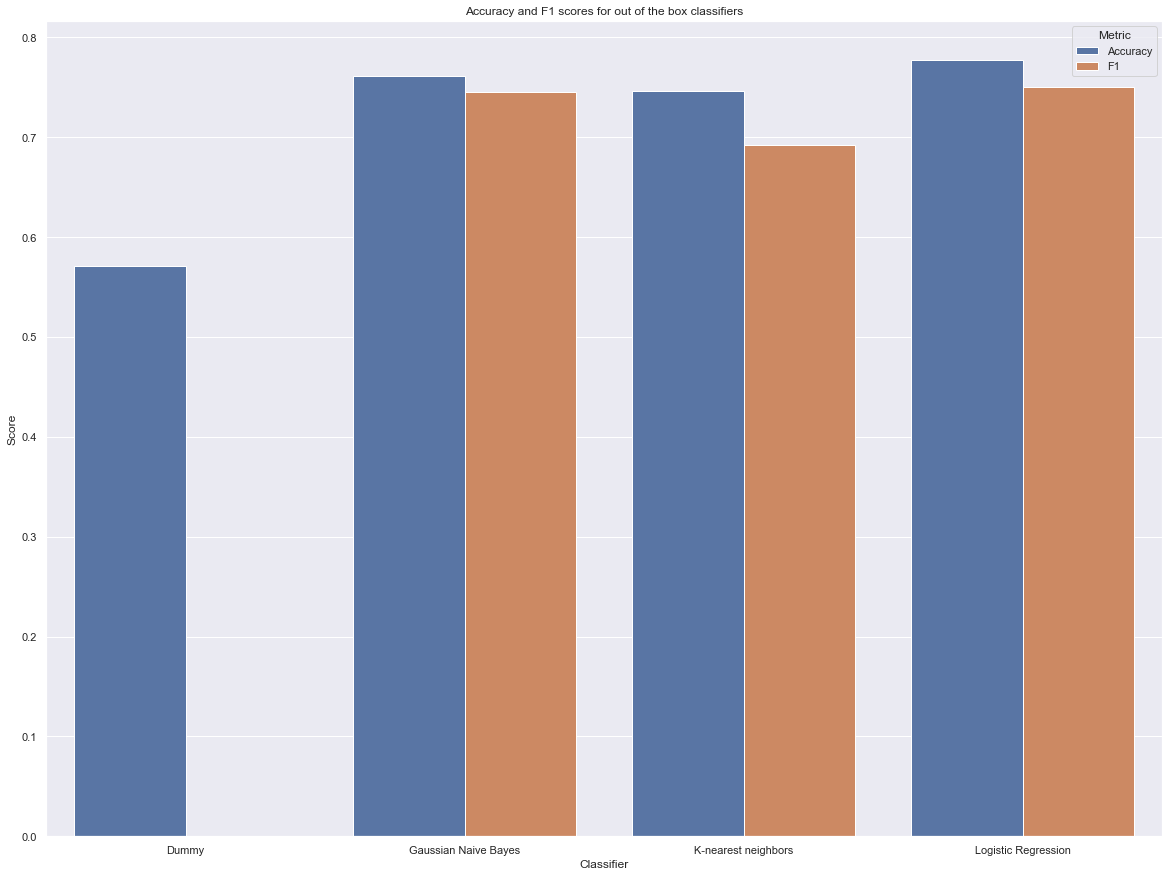

In [21]:
barplot = sns.barplot(data=out_of_the_box_scores,
                      y='Score',
                      x='Classifier',
                      hue='Metric')
barplot.set(title='Accuracy and F1 scores for out of the box classifiers')
plt.show()

Παραπάνω βλέπουμε την συμπεριφορά των ταξινομητών χωρίς καμία βελτιστοποίηση (out-of-the-box) και με όλες τις παραμέτρους σε default τιμές. Παρατηρούμε πως και για τις 2 μετρικές, οι επιδόσεις βελτιώνονται όταν περνάμε από τον Dummy στον Gaussian, μειώνονται όταν περνάμε από τον Gaussian στον kNN, ενώ αυξάνονται όταν περνάμε από τον kNN στον LR, όπου και εμφανίζονται οι μεγαλύτερες και στις 2 μετρικές. Από το διάγραμμα παρατηρούμε πως παρόλο που ο LR είναι αυτός που έχει τις μεγαλύτερες επιδόσεις, ο GNB έχει ελάχιστα μικρότερες, κάνοντας έτσι τους 2 ταξινομητές αυτούς με τις καλύτερες επιδόσεις. Ο kNN επίσης εμφανίζει αντίστοιχη επίδοση με μετρική accuracy με τους άλλους 2, αλλά "υστερεί" λίγο στο F1. Τέλος, ο Dummy, όπως και περιμέναμε, έχει τις χειρότερες επιδόσεις και στις 2 μετρικές αναλογικά με τους άλλους ταξινομητές που εξετάσαμε.

Συμπερασματικά, από τα παραπάνω καταλαβαίνουμε πως χωρίς καμία βελτιστοποίηση κυρίως οι ταξινομητές LR και GNB εμφανίζουν την καλύτερη επίδοση στις υπό εξέταση μετρικές (με καλύτερη επίδοση στον LR), ενώ ο Dummy παρουσιάζει την χαμηλότερη.

## Βελτιστοποίηση

### Ανάλυση Dataset

Με βάση το boxplot που φαίνεται παραπάνω παρατηρούμε πως θα βοηθούσε να κανονικοποιήσουμε τα δεδομένα μας. 

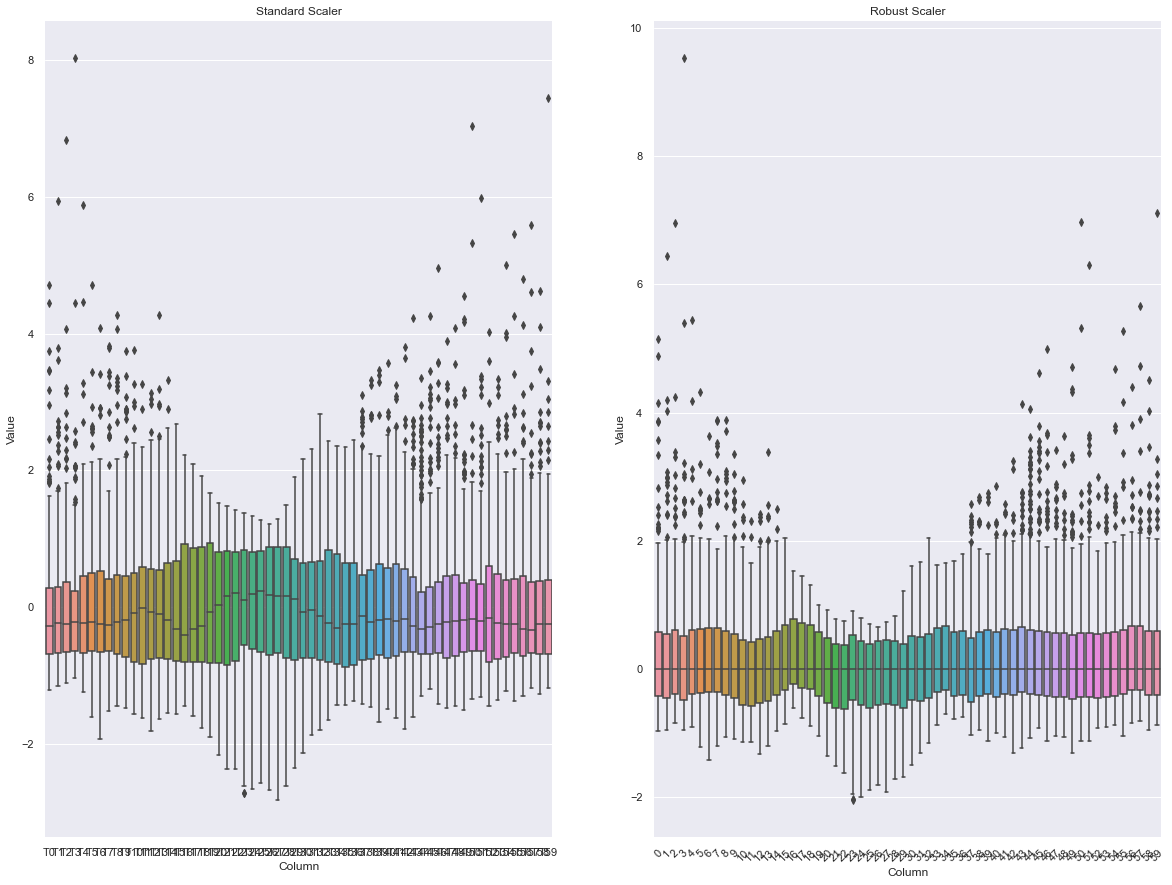

In [22]:
scaler = StandardScaler()
robust_scaler = RobustScaler()

scaler.fit_transform(features)
robust_scaler.fit_transform(features)

scaled_features = pd.DataFrame(scaler.fit_transform(features),
                               columns=features.columns)

fig, ax = plt.subplots(1, 2)

sns.boxplot(data=scaled_features, ax=ax[0]).set(title='Standard Scaler',
                                                xlabel='Column',
                                                ylabel='Value')
sns.despine(offset=2)
plt.xticks(rotation=45)
sns.boxplot(data=robust_scaler.fit_transform(features),
            ax=ax[1]).set(title='Robust Scaler',
                          xlabel='Column',
                          ylabel='Value')
sns.despine(offset=2)
plt.xticks(rotation=45)
plt.show()

Πράγματι, με την χρήση των Scaler φαίνεται ότι τα δεδομένα κανονικοποιήθηκαν, οπότε μπορούμε να τους χρησιμοποιήσουμε στην προσπάθεια βελτίωσης των επιδόσεων των ταξινομητών.

### Βοηθητικές συναρτήσεις

In [23]:
preprocessing_scores = pd.DataFrame()


def train_best_model(cv_classifier, classifier, scoring_metric):
    global preprocessing_scores
    out_of_the_box_score = lambda m: out_of_the_box_scores.loc[
        (out_of_the_box_scores['Classifier'] == classifier) &
        (out_of_the_box_scores['Metric'] == m)]['Score'].values[0]
    pipe = cv_classifier.best_estimator_

    start_time = time.time()
    pipe.fit(train, train_labels)
    train_time = time.time() - start_time

    start_time = time.time()
    preds = pipe.predict(test)
    test_time = time.time() - start_time

    score_acc = accuracy_score(test_labels, preds)
    score_f1 = f1_score(test_labels, preds)

    preprocessing_scores = preprocessing_scores.append(
        {
            "Classifier": classifier,
            "Scoring_metric": scoring_metric,
            "Accuracy": score_acc,
            "ΔAccuracy": score_acc - out_of_the_box_score('Accuracy'),
            "F1": score_f1,
            "ΔF1": score_f1 - out_of_the_box_score('F1'),
            "Train_time": train_time,
            "Test_time": test_time,
            "Preds": preds
        },
        ignore_index=True)


def use_cv(operations, scoring_metric, param_grid, classifier):
    pipe = Pipeline(steps=operations, memory='tmp')
    cv_classifier = GridSearchCV(pipe,
                                 param_grid,
                                 cv=10,
                                 scoring=scoring_metric,
                                 n_jobs=-1)
    cv_classifier.fit(train, train_labels)

    print('''Statistics for {} on {} scoring metric:
          Best Score = {}
          Best Estimator = {}'''.format(classifier, scoring_metric,
                                        cv_classifier.best_score_,
                                        cv_classifier.best_estimator_))
    return cv_classifier


def get_params(params_dicts, operations):
    params_dict = {}
    for (op_name, _) in operations:
        if op_name in params_dicts:
            for k, v in params_dicts[op_name].items():
                params_dict[op_name + '__' + k] = v
    return params_dict

Για την βελτιστοποίηση όλων των classifier χρησιμοποιήσαμε κάθε φορά ένα dictionary, το params_dicts, στο οποίο έχουμε τα operations και τις τιμές των υπερπαραμέτρων από τα οποία αντλούμε για να αποφανθούμε ποια θα οδηγήσουν στην βελτιστοποίηση του best score στο train set. Συγκεκριμένα, σε όλες τις περιπτώσεις κοινό έχουμε τον Robust Scaler με τις υπερπαραμέτρους with_centering, with_scaling και unit_variance, τον Standard Scaler, με τις υπερπαραμέτρους with_mean και with_std και το PCA, με την υπερπαράμετρο n_components να παίρνει τιμές από μια λίστα, όπως φαίνεται παρακάτω. Τέλος, χρησιμοποιήσαμε και το Select Percentile, το οποίο κάθε φορά επιλέγει τα χαρακτηριστικά με βάση ένα ποσοστό (που παίρνει από μια λίστα που φαίνεται παρακάτω) των καλύτερων scores. Καλό θα ήταν γενικά να αναφερθεί επίσης πως δοκιμάσαμε τόσο την χρήση του Random Oversampler όσο και του Variance Threshold, αλλά κανένα από τα 2 δεν φάνηκε να βοηθάει στην βελτιστοποίηση των επιδόσεων.

Παρακάτω θα δούμε αναλυτικότερα την διαδικασία που ακολουθήθηκε στην προσπάθεια βελτιστοποίησης καθενός από τους ζητούμενους classifiers.

### Dummy classifier

Στον Dummy classifier, στο params_dicts, πέρα από τα υπόλοιπα που αναφέρθηκαν έχουμε βάλει ταυτόχρονα στον ίδιο τον classifier να επιλέγει μεταξύ 4 στρατηγικών, και παραλείψαμε την στρατηγική constant, διότι δεν θέλουμε να προβλέπει μια συγκεκριμένη ετικέτα που θα δώσουμε εμείς.

In [24]:
params_dicts = {
    'robust_scaler': {
        'with_centering': [True, False],
        'with_scaling': [True, False],
        'unit_variance': [True, False],
    },
    'standard_scaler': {
        'with_mean': [True, False],
        'with_std': [True, False]
    },
    'pca': {
        'n_components': [i for i in range(10, 70, 10)]
    },
    'dummy': {
        'strategy': ['stratified', 'most_frequent', 'prior', 'uniform']
    },
    'select_percentile': {
        'percentile': [i for i in range(10, 110, 10)]
    }
}

#### Accuracy based scoring

Συγκεκριμένα τώρα με μετρική το accuracy, εξετάσαμε μια σειρά από περιπτώσεις και συνδυασμούς μεταξύ των προαναφερθέντων operations, με σκοπό να δούμε ποιος θα οδηγήσει σε μεγαλύτερο score. Αρχικά, δοκιμάσαμε μόνο με τον dummy operation, χωρίς να έχουμε μεγάλο score, όπως και περιμέναμε. Στην συνέχεια, με βάση τον dummy πάντα, όταν προσθέσαμε και scaler, αυξήθηκε και στους δύο scalers, αλλά με τον robust να είχε καλύτερο αποτέλεσμα. Ύστερα, αφαιρέσαμε τους scaler και βάλαμε PCA, αλλά οι επιδόσεις ουσιαστικά μειώθηκαν. Όταν στην συνέχεια βάλαμε και PCA και τους δύο scaler εναλλάξ μεταξύ τους, παρατηρήσαμε πως οι επιδόσεις γενικά αυξήθηκαν, με την μέγιστη από όλες να είναι η Standard Scaler + PCA, την οποία και τελικά χρησιμοποιήσαμε, όπως φαίνεται παρακάτω στα operations. Στο τέλος, βάλαμε και το Feature Selection επιπλεόν σε αυτά, αλλά η επίδοση έμεινε ουσιαστικά η ίδια, με ελάχιστη μείωση. Για αυτόν τον λόγο, λοιπόν, κρατάμε το Standard Scaler + PCA σαν την καλύτερη περίπτωση για τον Dummy με μετρική accuracy.

In [25]:
operations = [('standard_scaler', StandardScaler()), ('pca', PCA()),
              ('dummy', DummyClassifier())]

param_grid = get_params(params_dicts, operations)

dummy_acc_classifier = use_cv(operations, 'accuracy', param_grid, 'Dummy')

Statistics for Dummy on accuracy scoring metric:
          Best Score = 0.586190476190476
          Best Estimator = Pipeline(memory='tmp',
         steps=[('standard_scaler', StandardScaler(with_std=False)),
                ('pca', PCA(n_components=60)),
                ('dummy', DummyClassifier(strategy='uniform'))])


#### F1 based scoring

Την ίδια διαδικασία ακολουθήσαμε και για την μετρική του F1. Αρχικά, δοκιμάσαμε μόνο με τον dummy operation, χωρίς να έχουμε μεγάλο score, όπως και περιμέναμε. Στην συνέχεια, με βάση τον dummy πάντα, όταν προσθέσαμε και scaler, στον Standard μειώθηκε ενώ στον Robust έμεινε περίπου ίδιο. Περίπου ίδιο παρέμεινε και όταν αφαιρέσαμε τους scaler και βάλαμε μόνο το PCA. Στην συνέχεια, όταν βάλαμε και PCA και τους δύο scaler εναλλάξ, παρατήρησαμε ότι τα αποτελέσματα ήταν ξανά περίπου ίδια, με μια μικρή αύξηση. Στο τέλος, δοκιμάζοντας τόσο τους scaler, όσο και το Feature Selection και το PCA μαζί, τότε παρατηρήσαμε ότι σημειώθηκε αύξηση, με την μεγαλύτερη να σημειώνεται στο συνδυασμό Standard Scaler + Feature Selection + PCA, τον οποίο και τελικά χρησιμοποιήσαμε. Εδώ αξίζει να σημειωθεί πως o Dummy Classifier είχε διαφορετικό συνδυασμό για βελτιστοποίηση με μετρική το accuracy, και διαφορετικό με μετρική το F1.

In [26]:
operations = [('standard_scaler', StandardScaler()), ('select_percentile', SelectPercentile()), ('pca', PCA()),
              ('dummy', DummyClassifier())]

param_grid = get_params(params_dicts, operations)

dummy_f1_classifier = use_cv(operations, 'f1', param_grid, 'Dummy')

Statistics for Dummy on f1 scoring metric:
          Best Score = 0.6245545141133376
          Best Estimator = Pipeline(memory='tmp',
         steps=[('standard_scaler', StandardScaler()),
                ('select_percentile', SelectPercentile(percentile=50)),
                ('pca', PCA(n_components=10)),
                ('dummy', DummyClassifier(strategy='stratified'))])


### Gaussian Naive Bayes (GNB) classifier

Στον Gaussian Naive Bayes (GNB) classifier, στο params_dicts, πέρα από τα υπόλοιπα που αναφέρθηκαν έχουμε βάλει ταυτόχρονα στον ίδιο τον classifier την παράμετρο var_smoothing.

In [27]:
params_dicts = {
    'robust_scaler': {
        'with_centering': [True, False],
        'with_scaling': [True, False],
        'unit_variance': [True, False],
    },
    'standard_scaler': {
        'with_mean': [True, False],
        'with_std': [True, False]
    },
    'pca': {
        'n_components': [i for i in range(10, 70, 10)]
    },
    'select_percentile': {
        'percentile': [i for i in range(10, 110, 10)]
    },
    'gnb': {
        'var_smoothing': np.logspace(0, -9, 50)
    }
}

#### Accuracy based scoring

Την ίδια νοοτροπία ακολουθήσαμε και για τον GNB με μετρική accuracy. Αρχικά, δοκιμάσαμε μόνο με το gnb operation, χωρίς να έχουμε ιδιαίτερα μεγάλο score, όπως και περιμέναμε. Στην συνέχεια, με βάση τον gnb πάντα, όταν προσθέσαμε και scaler, δεν παρατηρήσαμε αύξηση σε κανένα από τους 2. Μεγάλη αύξηση παρατηρήσαμε όταν βγάλαμε τους scaler και βάλαμε μόνο το PCA. Στην συνέχεια, όταν μαζί με τον PCA βάλαμε και τους δύο scaler εναλλάξ, τότε παρατηρήσαμε πως υπήρχε μια μικρή βελτίωση αναλογικά με το PCA μόνο του, και για αυτό θεωρήσαμε και τον συνδυασμό Standard Scaler + PCA ως τον καλύτερο, τον οποίο και χρησιμοποιήσαμε κιόλας, όπως φαίνεται παρακάτω. Τέλος, όταν προσθέσαμε και Feature Selection μαζί με τα άλλα δύο που είχαμε πριν παρατηρούμε πως έβγαινε περίπου το ίδιο αποτέλεσμα, χωρίς ιδιαίτερη αλλαγή, οπότε και για αυτό αποφασίσαμε να χρησιμοποιήσουμε τον συνδυασμό Standard Scaler + PCA ως τον βέλτιστο.

In [28]:
operations = [('standard_scaler', StandardScaler()), ('pca', PCA()), ('gnb', GaussianNB())]

param_grid = get_params(params_dicts, operations)

gnb_acc_classifier = use_cv(operations, 'accuracy', param_grid,
                            'Gaussian Naive Bayes')

Statistics for Gaussian Naive Bayes on accuracy scoring metric:
          Best Score = 0.7938095238095237
          Best Estimator = Pipeline(memory='tmp',
         steps=[('standard_scaler', StandardScaler()),
                ('pca', PCA(n_components=60)),
                ('gnb', GaussianNB(var_smoothing=0.0517947467923121))])


#### F1 based scoring

Όπως και πριν, για μετρική F1 τώρα, αρχικά δοκιμάσαμε μόνο με το gnb operation, χωρίς να έχουμε ιδιαίτερα μεγάλο score, όπως και περιμέναμε. Στην συνέχεια, όταν βάλαμε τους δύο scaler εναλλάξ, παρατήρησαμε πως τα αποτελέσματα ήταν ουσιαστικά τα ίδια, με μια μικρή αύξηση. Όταν βγάλαμε τους scaler και βάλαμε το PCA μόνο του, τότε παρατηρήσαμε αύξηση περισσότερη από την αύξηση που είχαν προκαλέσει οι scaler μόνοι τους. Έτσι, όταν στην συνέχεια βάλαμε και το PCA και τους δύο scaler εναλλάξ, πήραμε την μέγιστη βελτίωση, την οποία και τελικά κρατήσαμε, στον συνδυασμό Standard Scaler + PCA. Στο τέλος, όταν βάλαμε επιπλέον και Feature Selection σε αυτά που είχαμε ήδη, τότε παρατηρήσαμε αποτέλεσμα ουσιαστικά ίδιο με το βέλτιστο, με μια μικρή μείωση, οδηγώντας μας έτσι στο συμπέρασμα πως στο GNB για την μετρική F1 ο βέλτιστος συνδυασμός είναι ο Standard Scaler + PCA, όπως ήταν και για την μετρική accuracy αντίστοιχα.

In [29]:
operations = [('standard_scaler', StandardScaler()), ('pca', PCA()), ('gnb', GaussianNB())]

param_grid = get_params(params_dicts, operations)

gnb_f1_classifier = use_cv(operations, 'f1', param_grid, 'Gaussian Naive Bayes')

Statistics for Gaussian Naive Bayes on f1 scoring metric:
          Best Score = 0.8021295886775764
          Best Estimator = Pipeline(memory='tmp',
         steps=[('standard_scaler', StandardScaler()),
                ('pca', PCA(n_components=30)),
                ('gnb', GaussianNB(var_smoothing=0.07906043210907697))])


### KNeirestNeighbors (kNN) classifier

Για την βελτιστοποίηση του KNeirestNeighbors (kNN) classifier, στο params_dicts, πέρα από αυτά που έχουν αναφερθεί χρησιμοποιήσαμε στον ίδιο τον classifier σαν υπερπαραμέτρους το n_neighbors, που είναι μια λίστα από την οποία επιλέγουμε τον "βέλτιστο" αριθμό από τους κοντινότερους γείτονες, το weights, που είναι η συνάρτηση βάρους που χρησιμοποιείται στην πρόβλεψη, καθώς και το metric, που είναι η μετρική της απόστασης. Επίσης, στον knn τον ίδιο χρησιμοποιήσαμε και την παράμετρο n_jobs ίση με -1, έτσι ώστε να χρησιμοποιηθούν όλοι οι processors στην αναζήτηση των γειτόνων, όπως φαίνεται παρακάτω.

In [30]:
params_dicts = {
    'robust_scaler': {
        'with_centering': [True, False],
        'with_scaling': [True, False],
        'unit_variance': [True, False],
    },
    'standard_scaler': {
        'with_mean': [True, False],
        'with_std': [True, False]
    },
    'pca': {
        'n_components': [i for i in range(10, 70, 10)]
    },
    'select_percentile': {
        'percentile': [i for i in range(10, 110, 10)]
    },
    'knn': {
        'n_neighbors': list(range(1, 31, 2)),
        'weights': ["uniform", "distance"],
        'metric': ["euclidean", "manhattan", "minkowski"]
    }
}

#### Accuracy based scoring

Με την ίδια λογική με πριν, για την μετρική accuracy του KNN αρχικά δοκιμάσαμε μόνο με το knn operation, στο οποίο παρατηρήσαμε γενικά μεγάλο score. Στην συνέχεια, με βάση πάντα το knn operation, όταν βάλαμε τους δύο scaler εναλλάξ, παρατηρήσαμε πως το αποτέλεσμα ήταν περίπου ίδιο, με μια μικρή αύξηση. Ύστερα, όταν βγάλαμε τους scalers και βάλαμε το PCA μόνο του παρατηρήσαμε μια μικρή μείωση. Ωστόσο, όταν μετά βάλαμε και το PCA αλλά και τους δύο scaler εναλλάξ, παρατηρήσαμε πως είχαμε αύξηση του αποτελέσματος αναλογικά με το αποτέλεσμα που έδινε το PCA μόνο του. Τέλος, όταν στον συνδυασμό αυτό προσθέσαμε και το Feature Selection, τότε παρατηρήσαμε πως η επίδοση ανέβηκε ακόμα περισσότερο από ότι πριν, με αποτέλεσμα να θεωρούμε τον συνδυασμό Standard Scaler + Feature Selection + PCA ως τον βέλτιστο για τον KNN με την μετρική accuracy.

In [31]:
operations = [('standard_scaler', StandardScaler()),
              ('select_percentile', SelectPercentile()), ('pca', PCA()),
              ('knn', KNeighborsClassifier(n_jobs=-1))]

param_grid = get_params(params_dicts, operations)

knn_acc_classifier = use_cv(operations, 'accuracy', param_grid,
                            'K-nearest neighbors')

Statistics for K-nearest neighbors on accuracy scoring metric:
          Best Score = 0.8828571428571429
          Best Estimator = Pipeline(memory='tmp',
         steps=[('standard_scaler', StandardScaler()),
                ('select_percentile', SelectPercentile(percentile=100)),
                ('pca', PCA(n_components=20)),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_jobs=-1,
                                      n_neighbors=1))])


#### F1 based scoring

Όμοια με πριν, για την μετρική F1 τώρα, αρχικά δοκιμάσαμε μόνο με το knn operation, στο οποίο παρατηρήσαμε γενικά μεγάλο score. Στην συνέχεια, με βάση πάντα το knn operation, όταν βάλαμε τους δύο scaler εναλλάξ, παρατηρήσαμε πως το αποτέλεσμα ήταν περίπου ίδιο, με μια μικρή αύξηση. Ύστερα, όταν βγάλαμε τους scalers και βάλαμε το PCA μόνο του παρατηρήσαμε μια μικρή μείωση. Ωστόσο, όταν μετά βάλαμε και το PCA αλλά και τους δύο scaler εναλλάξ, παρατηρήσαμε ότι στον Standard είχαμε αποτέλεσμα καλύτερο από το αρχικό score, ενώ στον Robust είχαμε ελαφρώς μικρότερο. Τέλος, όταν στον συνδυασμό αυτό προσθέσαμε και το Feature Selection, τότε παρατηρήσαμε πως η επίδοση ανέβηκε το περισσότερο που είχε ανέβει από όλες τις περιπτώσεις, με αποτέλεσμα να θεωρούμε τον συνδυασμό Standard Scaler + Feature Selection + PCA ως τον βέλτιστο για τον KNN με την μετρική F1, όπως ακριβώς συνέβη και στην μετρική accuracy.

In [32]:
operations = [('standard_scaler', StandardScaler()),
              ('select_percentile', SelectPercentile()), ('pca', PCA()),
              ('knn', KNeighborsClassifier(n_jobs=-1))]

param_grid = get_params(params_dicts, operations)

knn_f1_classifier = use_cv(operations, 'f1', param_grid, 'K-nearest neighbors')

Statistics for K-nearest neighbors on f1 scoring metric:
          Best Score = 0.8772888386123681
          Best Estimator = Pipeline(memory='tmp',
         steps=[('standard_scaler', StandardScaler()),
                ('select_percentile', SelectPercentile(percentile=100)),
                ('pca', PCA(n_components=30)),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_jobs=-1,
                                      n_neighbors=1))])


### Logistic Regression (LR) classifier

Για την βελτιστοποίηση του Logistic Regression (LR) classifier, στο params_dict, πέρα από αυτά που αναφέρθηκαν στην αρχή, χρησιμοποιήσαμε σαν υπερπαραμέτρους του ίδιου του classifier το penalty, το οποίο παίρνει μια από τις παρακάτω 3 τιμές, το fit_intercept, για το αν μια σταθερά πρέπει να προστεθεί στην συνάρτηση απόφασης, καθώς και το C, που παίρνει τιμές από μια λίστα, όπως φαίνεται παρακάτω. Επίσης, στον ίδιο τον classifier χρησιμοποιήσαμε την παράμετρο n_jobs ίση με -1, έτσι ώστε να χρησιμοποιηθούν όλοι οι processors στην διαδικασία, καθώς και τον solver saga, όπως παρουσιάζεται παρακάτω.

In [33]:
params_dicts = {
    'robust_scaler': {
        'with_centering': [True, False],
        'with_scaling': [True, False],
        'unit_variance': [True, False],
    },
    'standard_scaler': {
        'with_mean': [True, False],
        'with_std': [True, False]
    },
    'pca': {
        'n_components': [i for i in range(10, 70, 10)]
    },
    'select_percentile': {
        'percentile': [i for i in range(10, 110, 10)]
    },
    'lr': {
        'penalty': ["l1", "l2", "elasticnet"],
        'fit_intercept': [True, False],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    }
}

#### Accuracy based scoring

Αντίστοιχα με την διαδικασία που ακολουθήσαμε στις προηγούμενες περιπτώσεις, έτσι και εδώ, αρχικά δοκιμάσαμε μόνο με το lr operation, στο οποίο παρατηρήσαμε γενικά καλό score. Στην συνέχεια, με βάση πάντα το lr operation, όταν βάλαμε τους δύο scaler εναλλάξ, παρατηρήσαμε πως το αποτέλεσμα ήταν περίπου ίδιο, με μια μικρή αύξηση. Όταν στην συνέχεια αφαιρέσαμε τους scaler και βάλαμε μόνο PCA, τότε το αποτέλεσμα αυξήθηκε ακόμα περισσότερο. Ύστερα, όταν μαζί με το PCA βάλαμε εναλλάξ τους scaler, τότε παρατηρήσαμε πως το αποτέλεσμα δεν άλλαξε ιδιαίτερα. Τέλος, με την προσθήκη του Feature Selection στον παραπάνω συνδυασμό, το αποτέλεσμα έμεινε ίδιο με μια αύξηση που ουσιαστικά ήταν και η μέγιστη που παρατηρήσαμε, με αποτέλεσμα να θεωρούμε τον συνδυασμό Standard Scaler + Feature Selection + PCA ως τον βέλτιστο για το Logistic Regression με μετρική accuracy.

In [34]:
operations = [('standard_scaler', StandardScaler()), ('select_percentile', SelectPercentile()), ('pca', PCA()),
              ('lr', LogisticRegression(n_jobs=-1, solver="saga"))]

param_grid = get_params(params_dicts, operations)

lr_acc_classifier = use_cv(operations, 'accuracy', param_grid,
                           'Logistic Regression')

Statistics for Logistic Regression on accuracy scoring metric:
          Best Score = 0.8161904761904764
          Best Estimator = Pipeline(memory='tmp',
         steps=[('standard_scaler', StandardScaler()),
                ('select_percentile', SelectPercentile(percentile=90)),
                ('pca', PCA(n_components=30)),
                ('lr',
                 LogisticRegression(C=10, n_jobs=-1, penalty='l1',
                                    solver='saga'))])


#### F1 based scoring

Αντίστοιχα με την διαδικασία που ακολουθήσαμε πριν, για το Logistic Regression με μετρική F1 αρχικά δοκιμάσαμε πάλι μόνο με το lr operation, στο οποίο παρατηρήσαμε γενικά καλό score. Στην συνέχεια, με βάση πάντα το lr operation, όταν βάλαμε τους δύο scaler εναλλάξ, παρατηρήσαμε πως το αποτέλεσμα παρουσίασε μια μικρή αύξηση. Όταν στην συνέχεια αφαιρέσαμε τους scaler και βάλαμε μόνο PCA, τότε το αποτέλεσμα αυξήθηκε ακόμα περισσότερο. Ύστερα, όταν μαζί με το PCA βάλαμε εναλλάξ τους scaler, τότε παρατηρήσαμε πως το αποτέλεσμα δεν άλλαξε ιδιαίτερα. Τέλος, με την προσθήκη του Feature Selection στον παραπάνω συνδυασμό, το αποτέλεσμα έμεινε ίδιο με μια αύξηση που ουσιαστικά ήταν και η μέγιστη που παρατηρήσαμε, με αποτέλεσμα να θεωρούμε τον συνδυασμό Standard Scaler + Feature Selection + PCA ως τον βέλτιστο για το Logistic Regression με μετρική F1, όπως ακριβώς συνέβη και στην μετρική accuracy.

In [35]:
operations = [('standard_scaler', StandardScaler()), ('select_percentile', SelectPercentile()), ('pca', PCA()),
              ('lr', LogisticRegression(n_jobs=-1, solver="saga"))]

param_grid = get_params(params_dicts, operations)

lr_f1_classifier = use_cv(operations, 'f1', param_grid, 'Logistic Regression')

Statistics for Logistic Regression on f1 scoring metric:
          Best Score = 0.8148577892695539
          Best Estimator = Pipeline(memory='tmp',
         steps=[('standard_scaler', StandardScaler()),
                ('select_percentile', SelectPercentile(percentile=100)),
                ('pca', PCA(n_components=30)),
                ('lr',
                 LogisticRegression(C=0.1, fit_intercept=False, n_jobs=-1,
                                    solver='saga'))])


## Εκπαίδευση και test βέλτιστων μοντέλων

In [36]:
train_best_model(dummy_acc_classifier, 'Dummy', 'accuracy')

In [37]:
train_best_model(dummy_f1_classifier, 'Dummy', 'f1')

In [38]:
train_best_model(gnb_acc_classifier, 'Gaussian Naive Bayes', 'accuracy')

In [39]:
train_best_model(gnb_f1_classifier, 'Gaussian Naive Bayes', 'f1')

In [40]:
train_best_model(knn_acc_classifier, 'K-nearest neighbors', 'accuracy')

In [41]:
train_best_model(knn_f1_classifier, 'K-nearest neighbors', 'f1')

In [42]:
train_best_model(lr_acc_classifier, 'Logistic Regression', 'accuracy')

In [43]:
train_best_model(lr_f1_classifier, 'Logistic Regression', 'f1')

## Αποτελέσματα και συμπεράσματα

Παρακάτω παρουσιάζεται ο πίνακας με όλα τα αποτελέσματα, δηλαδή για κάθε ταξινομητή και για κάθε μετρική σε αυτόν παρουσιάζεται το accuracy, το f1, η διαφορά του καθενός από αυτά σε σχέση με το out-of-the-box, καθώς και οι χρόνοι train_time και test_time, για τον χρόνο που απαιτήθηκε αντίστοιχα για την εκπαίδευση και τον "έλεγχο" του ταξινομητή.

In [44]:
preprocessing_scores[preprocessing_scores.columns.drop('Preds')].groupby(
    'Classifier').apply(lambda a: a.drop('Classifier', axis=1)[:])

Scoring_metric  Accuracy  ΔAccuracy        F1  \
Classifier                                                             
Dummy                0       accuracy  0.571429   0.000000  0.448980   
                     1             f1  0.619048   0.047619  0.571429   
Gaussian Naive Bayes 2       accuracy  0.809524   0.047619  0.777778   
                     3             f1  0.761905   0.000000  0.736842   
K-nearest neighbors  4       accuracy  0.888889   0.142857  0.867925   
                     5             f1  0.888889   0.142857  0.862745   
Logistic Regression  6       accuracy  0.809524   0.031746  0.793103   
                     7             f1  0.777778   0.000000  0.758621   

                             ΔF1  Train_time  Test_time  
Classifier                                               
Dummy                0  0.448980    0.028922   0.334876  
                     1  0.571429    0.029922   0.001994  
Gaussian Naive Bayes 2  0.032015    0.017953   0.002991  
                     3 -0.008921    0.014959   0.002992  
K-nearest neighbors  4  0.175617    0.022938   0.116688  
                     5  0.170437    0.015989   0.122640  
Logistic Regression  6  0.043103    0.138215   0.002026  
                     7  0.008621    0.121674   0.002992

Από τα παραπάνω παρατηρούμε πως τόσο με μετρική accuracy όσο και με μετρική f1, το βέλτιστο accuracy το πετυχαίνουμε στο kNN με 0.88 περίπου, και ύστερα ακολουθούν o LR και ο GNB με παραπλήσιες μεταξύ τους τιμές. Αντίστοιχα, τόσο με μετρική accuracy όσο και με μετρική f1, το βέλτιστο f1 το παρουσιάζει πάλι ο kNN με 0.86 περίπου, και ύστερα ακολουθούν με σειρά οι LR και GNB. Ο ταξινομητής Dummy, όπως και περιμέναμε, εμφανίζει σταθερά τις χαμηλότερες επιδόσεις και στις 2 μετρικές. Όσον αφορά τώρα στις μεταβολές, η μέγιστη μεταβολή στο accuracy εμφανίζεται στον kNN, κάτι το οποίο κιόλας αιτιολογεί και την μέγιστη επίδοση στο accuracy, ενώ στα υπόλοιπα εμφανίζεται είτε μια μικρή βελτίωση είτε μηδενική σε κάποιες περιπτώσεις όπως στον Dummy. Στο F1, η μέγιστη μεταβολή εμφανίζεται στον Dummy, με αρκετά μεγάλες τιμές, ενώ ακολουθεί πάλι ο kNN ο οποίος εμφανίζει μεγάλη μεταβολή και στην μετρική F1, πάλι εξηγώντας κατά κάποιο τρόπο έτσι το γεγονός πως έχει την μέγιστη επίδοση F1. Οι υπόλοιποι ταξινομητές παρουσιάζουν μια μικρή αύξηση. Όσον αφορά τώρα στους χρόνους train και test, αναμέναμε ο kNN να έχει μεγάλο χρόνο test καθώς πρέπει να υπολογίζει όλες τις αποστάσεις μεταξύ γειτόνων. Επίσης, περιμέναμε o GNB να είναι γρήγορος και στα δύο, αφού στο train θέλει απλές στατιστικές μ και σ, ενώ στο συμπέρασμα υπολογίζει πόσο του δίνει η γκαουσσιανή της κάθε κλάσης.

Στην συνέχεια, φτιάχνουμε bar plots για να οπτικοποιηθεί η διαφορά μεταξύ των αποτελεσμάτων που παρουσιάστηκαν και επεξηγήθηκαν παραπάνω.

In [45]:
to_plot_scores = preprocessing_scores[[
    'Classifier', 'Scoring_metric', 'Accuracy', 'F1'
]]

to_plot_differences = preprocessing_scores[[
    'Classifier', 'Scoring_metric', 'ΔAccuracy', 'ΔF1'
]]

In [46]:
migration = lambda x: {
    'Classifier':
        x,
    'Scoring_metric':
        'Out of the box',
    'Accuracy':
        out_of_the_box_scores.loc[
            (out_of_the_box_scores['Classifier'] == x) &
            (out_of_the_box_scores['Metric'] == 'Accuracy')]['Score'].values[0],
    'F1':
        out_of_the_box_scores.loc[
            (out_of_the_box_scores['Classifier'] == x) &
            (out_of_the_box_scores['Metric'] == 'F1')]['Score'].values[0],
}

old_scores = pd.DataFrame()
for clf in np.unique(out_of_the_box_scores['Classifier']):
    old_scores = old_scores.append(migration(clf), ignore_index=True)
to_plot_scores = old_scores.append(to_plot_scores, ignore_index=True)

[]

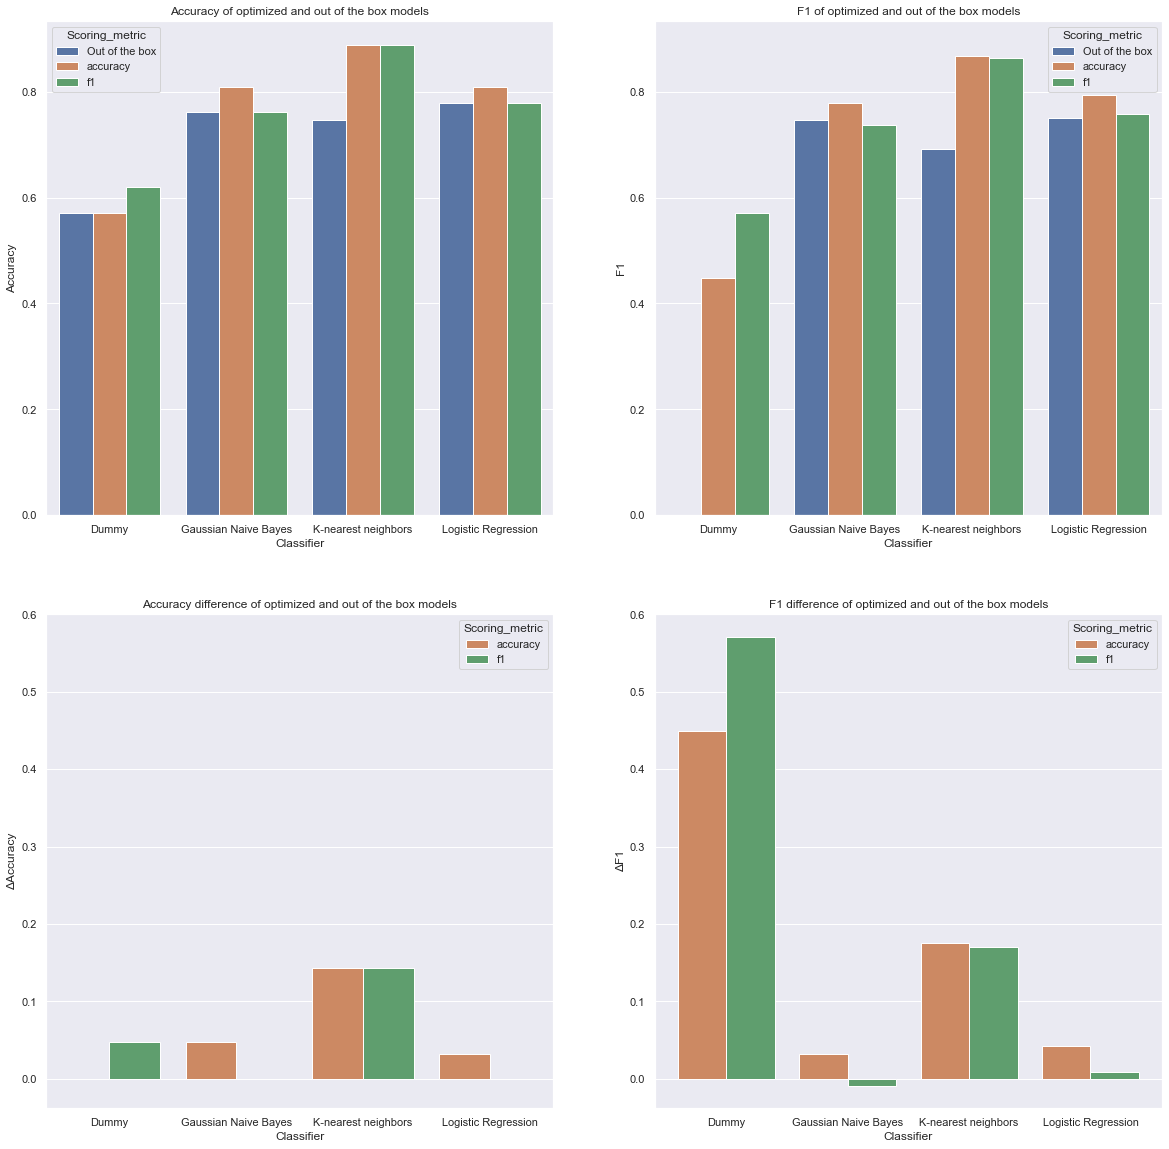

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axs[0][0].get_shared_y_axes().join(axs[0][0], axs[0][1])
axs[1][0].get_shared_y_axes().join(axs[1][0], axs[1][1])

sns.barplot(
    data=to_plot_scores,
    y='Accuracy',
    x='Classifier',
    hue="Scoring_metric",
    ax=axs[0][0]).set_title("Accuracy of optimized and out of the box models")

sns.barplot(data=to_plot_scores,
            y='F1',
            x='Classifier',
            hue="Scoring_metric",
            ax=axs[0][1]).set_title("F1 of optimized and out of the box models")

sns.barplot(data=to_plot_differences,
            y='ΔAccuracy',
            x='Classifier',
            hue="Scoring_metric",
            palette=["C1", "C2"],
            ax=axs[1][0]).set_title(
                "Accuracy difference of optimized and out of the box models")
sns.barplot(data=to_plot_differences,
            y='ΔF1',
            x='Classifier',
            hue="Scoring_metric",
            palette=["C1", "C2"],
            ax=axs[1][1]).set_title(
                "F1 difference of optimized and out of the box models")

plt.plot()

Παραπάνω παρουσιάζονται τόσο τα διαγραμμάτα που δείχνουν τα αποτελέσματα των μετρικών (από τα οποία φαίνεται η μεταβολή που υπήρξε), όσο και τα διαγράμματα τα οποία αναφέρονται μόνο στην μεταβολή που παρουσιάστηκε, για να είναι πιο εύκολα ορατή. Συγκεκριμένα, στα πάνω διαγράμματα, έχουμε ένα διάγραμμα που αναφέρεται στο accuracy μόνο, δηλαδή συγκρίνει το out-of-the-box accuracy κάθε ταξινομητή με το accuracy σε accuracy metric και το accuracy σε f1 metric του ταξινομητή, και ένα άλλο διάγραμμα που αναφέρεται μόνο στο f1, δηλαδή για κάθε ταξινομητή παρουσιάζει τις επιδόσεις f1 σε out-of-the-box, με metric accuracy και με metric f1, από τα οποία μπορεί να δει κανείς την μεταβολή που υπάρχει μεταξύ του out-of-the-box και της βελτιστοποίησης, συγκρίνοντας τα ύψη των bars. Στα κάτω διαγράμματα τώρα, έχουμε πάλι ένα που αναφέρεται στο accuracy και ένα που αναφέρεται στο f1 και στα οποία φαίνεται τώρα μόνο η μεταβολή στην επίδοση, για να είναι ευκολότερα αντιληπτή. Στα διαγράμματα φαίνονται τα αποτελέσματα που παρουσιάσαμε στον markdown πίνακα (χωρίς τους χρόνους) καθώς και τα σχόλια και οι παρατηρήσεις που κάναμε πάνω σε αυτά.

Στην συνέχεια, για τον καλύτερο και τον χειρότερο ταξινομητή (εξαιρουμένων των dummy) ως προς την ορθότητα από τους βελτιστοποιημένους θα εκτυπώσουμε τους πίνακες σύγχυσης με γραφικό τρόπο.

In [48]:
without_dummy = preprocessing_scores.loc[
    preprocessing_scores['Classifier'] != 'Dummy']
worst_model = without_dummy[without_dummy['Accuracy'] ==
                            without_dummy['Accuracy'].min()].iloc[0]
best_model = without_dummy[without_dummy['Accuracy'] ==
                           without_dummy['Accuracy'].max()].iloc[0]

print('''Worst model is {} with scoring metric {} and accuracy {:.3f}
Best model is {} with scoring metric {} and accuracy {:.3f}'''.format(
    worst_model['Classifier'], worst_model['Scoring_metric'],
    worst_model['Accuracy'], best_model['Classifier'],
    best_model['Scoring_metric'], best_model['Accuracy']))

Worst model is Gaussian Naive Bayes with scoring metric f1 and accuracy 0.762
Best model is K-nearest neighbors with scoring metric accuracy and accuracy 0.889


In [49]:
worst_cf_matrix = confusion_matrix(worst_model['Preds'], test_labels)
best_cf_matrix = confusion_matrix(best_model['Preds'], test_labels)

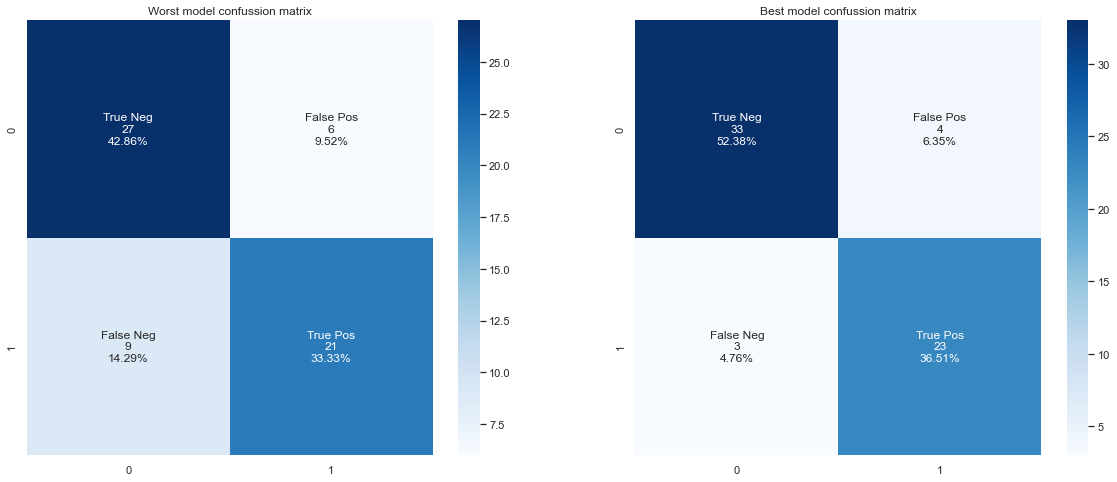

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in worst_cf_matrix.flatten()]
group_percentages = [
    '{0:.2%}'.format(value)
    for value in worst_cf_matrix.flatten() / np.sum(worst_cf_matrix)
]
labels = [
    f'{v1}\n{v2}\n{v3}'
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(worst_cf_matrix, annot=labels, fmt='', cmap='Blues',
            ax=axs[0]).set_title('Worst model confussion matrix')

group_counts = ['{0:0.0f}'.format(value) for value in best_cf_matrix.flatten()]
group_percentages = [
    '{0:.2%}'.format(value)
    for value in best_cf_matrix.flatten() / np.sum(best_cf_matrix)
]
labels = [
    f'{v1}\n{v2}\n{v3}'
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(best_cf_matrix, annot=labels, fmt='', cmap='Blues',
            ax=axs[1]).set_title('Best model confussion matrix')

plt.show()

Όπως φαίνεται και παραπάνω, ο χειρότερος ως προς την ορθότητα βελτιστοποιημένος ταξινομητής είναι ο Gaussian Naive Bayes με μετρική f1, ενώ ο καλύτερος είναι ο K-nearest neighbors με μετρική accuracy. Έτσι, βλέπουμε την γραφική αναπαράσταση των πινάκων σύγχυσής τους. Παρατηρούμε, πως ο χειρότερος ταξινομητής έχει μικρότερα ποσοστά από True Negative και True Positive από τον βέλτιστο, και επίσης μεγαλύτερα ποσοστά στα False Negative και False Positive, κάτι το οποίο είναι λογικό, εφόσον αυτό δείχνει πως ο ταξινομητής δεν πρόβλεψε τόσο σωστά το ποια δείγματα ανήκαν σε ποιες κλάσεις αναλογικά με τον βέλτιστο, και για αυτό είχε και μικρότερο accuracy από τον βέλτιστο. Φαίνεται και γραφικά μάλιστα αυτό, με τα χρώματα των "κουτιών" να είναι πιο σκούρα σε απόχρωση όσο μεγαλύτερο ποσοστό πιάνει η συγκεκριμένα κατηγορία. Στο καλύτερο μοντέλο το μεγαλύτερο ποσοστό το έχει το True Negative και ύστερα το True Positive, με τις υπόλοιπες 2 κατηγορίες να μην έχουν ουσιαστικά χρώμα, εφόσον είναι πολύ μικρές, ενώ στο χειρότερο μοντέλο, ναι μεν ισχύει το ίδιο με το βέλτιστο, αλλά η κατηγορία False Negative (που είναι "κακή" γενικά), έχει αποκτήσει πιο σκούρη απόχρωση, και αυτό γιατί αποτελεί μεγαλύτερο ποσοστό στο σύνολο.

Συμπερασματικά, και από όλα τα παραπάνω, για το συγκεκριμένο πρόβλημα θα προτείναμε τον βελτιστοποιημένο K-Nearest Neighbors, και αυτό γιατί όπως φαίνεται και στα αποτελέσματα παραπάνω παρουσιάζει και με τις 2 μετρικές τις βέλτιστες επιδόσεις και για accuracy και για f1, κάνοντάς τον έτσι κατάλληλο για να ανταπεξέλθει στο πρόβλημά μας. Επίσης, παρόλο που ο kNN εμφανίζει το μεγαλύτερο test time (όπως περιμέναμε) δεν υπάρχει κάποιο σοβαρό trade-off μεταξύ επίδοσης και χρόνου ή υπολογιστικών πόρων, εφόσον ο όγκος του dataset είναι σχετικά μικρός και όλα τα μοντέλα εκπαιδεύονται και γίνονται tested ουσιαστικά στο ίδιο μικρό χρονικό διάστημα, δηλαδή είναι τόσο μικρός ο χρόνος που ουσιαστικά δεν υπάρχει τόσο μεγάλη διαφορά που να μας αναγκάσει να πάρουμε άλλον ταξινομητή (όπως τον LR ή τον GNB) που να έχουν μικρότερες επιδόσεις γενικά αλλά να γίνονται "πιο γρήγορα". Η καλή επίδοση του kNN γενικά μπορεί να ερμηνευθεί τόσο στην υλοποίησή του σαν ταξινομητή, αλλά και από το πλήθος των operations και των υπερπαραμέτρων που χρησιμοποιήθηκαν για την βελτιστοποίησή του, και οι οποίες κατάφεραν να επιφέρουν καλύτερα αποτέλεσμα, σε αντίθεση με τον GNB πχ που εκτός της υλοποίησής του σαν ταξινομητή, το Select Percentile σε εκείνον δεν κατάφερε να βοηθήσει στο να γίνει καλύτερος, με αποτέλεσμα ενδεχομένως να μην κατάφερε να έχει τόσο καλές επιδόσεις.